# Part 2

This notebook will answer all the questions in part 2

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Dataset Preparation 

First, we define all relevant hyperparameters, then we load the dataset.

After which, we will load the word embeddings and process the data accordingly

In [2]:
BATCH_SIZE = 32

In [3]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

### Word Embedding

We load the pre-trained Google News 300 dimension Word2Vec model and obtain a word index to be used later in data processing

In [4]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [5]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

### Dataloaders

Once we have the dataset and the word index both loaded, we can proceed with building the dataloaders for batch training. We first prepare the data by tokenizing and padding the data so that they are all of the same length

In [6]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

Once the data is processed, we create dataloaders for the data for batch training

In [7]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

## Model

Once again, we define all relevant hyperparameters

In [8]:
LR = 0.0001
MODEL_TYPE = "rnn"

### 1. Default RNN

We initialise the model for the default RNN without any extra processing to derive the final sentence representation

In [9]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [10]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode=None
)

Epoch   1/100, Loss: 0.6977, Accuracy: 0.4981
Model saved.
Epoch   2/100, Loss: 0.6914, Accuracy: 0.5225
Model saved.
Epoch   3/100, Loss: 0.6787, Accuracy: 0.5844
Model saved.
Epoch   4/100, Loss: 0.6625, Accuracy: 0.5629
Epoch   5/100, Loss: 0.6492, Accuracy: 0.5807
Epoch   6/100, Loss: 0.6349, Accuracy: 0.5985
Model saved.
Epoch   7/100, Loss: 0.6251, Accuracy: 0.5788
Epoch   8/100, Loss: 0.6114, Accuracy: 0.5872
Epoch   9/100, Loss: 0.6030, Accuracy: 0.5704
Epoch  10/100, Loss: 0.5884, Accuracy: 0.5722
Epoch  11/100, Loss: 0.5765, Accuracy: 0.5694
Epoch  12/100, Loss: 0.5617, Accuracy: 0.5694
Epoch  13/100, Loss: 0.5481, Accuracy: 0.5657
Epoch  14/100, Loss: 0.5367, Accuracy: 0.5816
Epoch  15/100, Loss: 0.5233, Accuracy: 0.5722
Epoch  16/100, Loss: 0.5130, Accuracy: 0.5619
Early stopping triggered after 16 epochs.
Training ended, loading best model...
Model loaded.


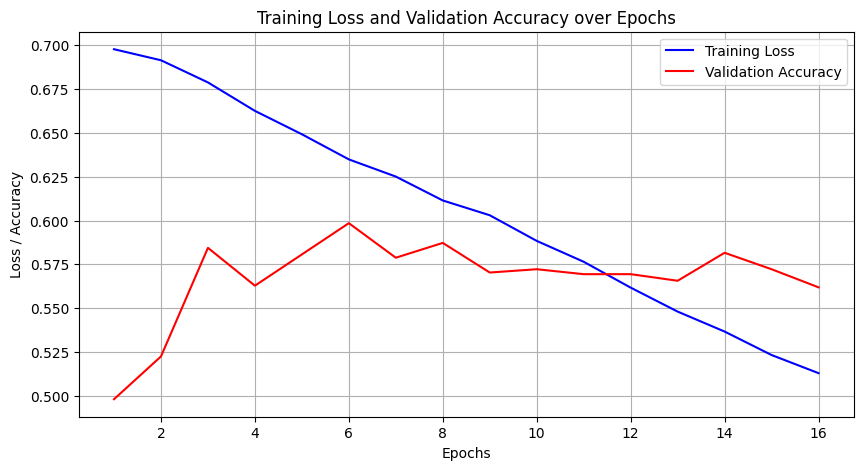

In [11]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [12]:
rnn_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5985


Test the model on the test set to obtain the accuracy

In [13]:
rnn_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5985


### 2. Last State RNN

This RNN will pick the hidden vector from the last time step as the sentence representation. This approach assumes that the last hidden state will capture the overall meaning of the sentence

In [14]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [15]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state" # train only the last state
)

Epoch   1/100, Loss: 0.6960, Accuracy: 0.4897
Model saved.
Epoch   2/100, Loss: 0.6896, Accuracy: 0.5159
Model saved.
Epoch   3/100, Loss: 0.6773, Accuracy: 0.5732
Model saved.
Epoch   4/100, Loss: 0.6595, Accuracy: 0.5844
Model saved.
Epoch   5/100, Loss: 0.6423, Accuracy: 0.5694
Epoch   6/100, Loss: 0.6330, Accuracy: 0.5966
Model saved.
Epoch   7/100, Loss: 0.6203, Accuracy: 0.5647
Epoch   8/100, Loss: 0.6050, Accuracy: 0.5694
Epoch   9/100, Loss: 0.5913, Accuracy: 0.5760
Epoch  10/100, Loss: 0.5783, Accuracy: 0.5666
Epoch  11/100, Loss: 0.5657, Accuracy: 0.5826
Epoch  12/100, Loss: 0.5486, Accuracy: 0.5685
Epoch  13/100, Loss: 0.5388, Accuracy: 0.5760
Epoch  14/100, Loss: 0.5237, Accuracy: 0.5779
Epoch  15/100, Loss: 0.5146, Accuracy: 0.5732
Epoch  16/100, Loss: 0.5017, Accuracy: 0.5750
Early stopping triggered after 16 epochs.
Training ended, loading best model...
Model loaded.


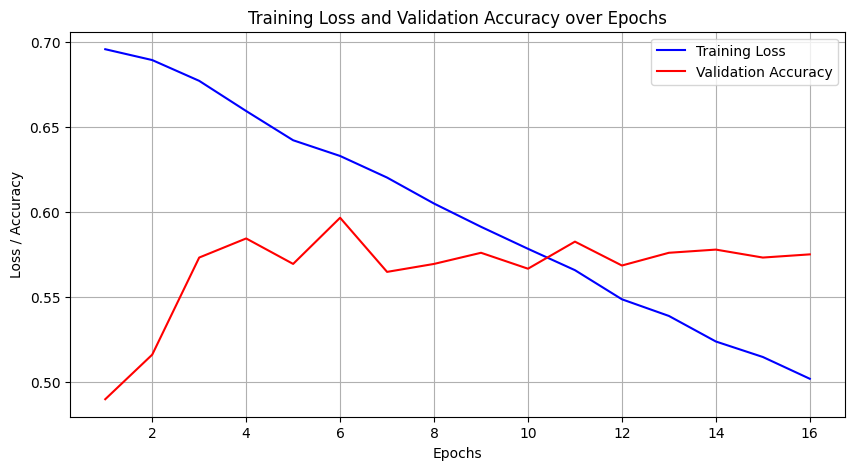

In [16]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [17]:
last_state_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5966


Test the model on the test set to obtain the accuracy

In [18]:
last_state_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5994


### 3. Mean Pooling RNN

This RNN will use the average of all hidden vectors as the sentence representation. This captures information across the whole sentence by averaging the all the words' contributions

In [19]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [20]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pool" # train only the mean pool
)

Epoch   1/100, Loss: 0.6966, Accuracy: 0.5028
Model saved.
Epoch   2/100, Loss: 0.6887, Accuracy: 0.5263
Model saved.
Epoch   3/100, Loss: 0.6735, Accuracy: 0.5704
Model saved.
Epoch   4/100, Loss: 0.6576, Accuracy: 0.5769
Model saved.
Epoch   5/100, Loss: 0.6437, Accuracy: 0.5882
Model saved.
Epoch   6/100, Loss: 0.6363, Accuracy: 0.5816
Epoch   7/100, Loss: 0.6233, Accuracy: 0.5891
Model saved.
Epoch   8/100, Loss: 0.6077, Accuracy: 0.5872
Epoch   9/100, Loss: 0.5950, Accuracy: 0.5732
Epoch  10/100, Loss: 0.5820, Accuracy: 0.5694
Epoch  11/100, Loss: 0.5703, Accuracy: 0.5666
Epoch  12/100, Loss: 0.5543, Accuracy: 0.5450
Epoch  13/100, Loss: 0.5405, Accuracy: 0.5647
Epoch  14/100, Loss: 0.5320, Accuracy: 0.5610
Epoch  15/100, Loss: 0.5179, Accuracy: 0.5732
Epoch  16/100, Loss: 0.5047, Accuracy: 0.5694
Epoch  17/100, Loss: 0.4921, Accuracy: 0.5647
Early stopping triggered after 17 epochs.
Training ended, loading best model...
Model loaded.


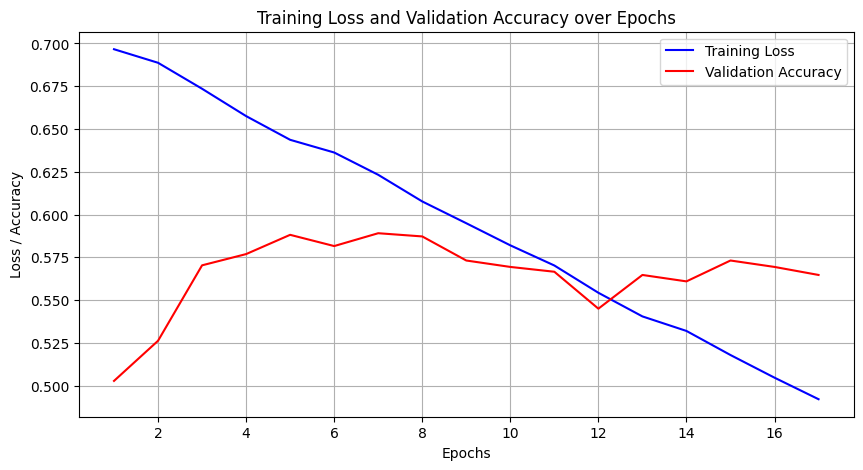

In [21]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [22]:
mean_pool_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5891


Test the model on the test set to obtain the accuracy

In [23]:
mean_pool_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5591


### 4. Max Pool RNN

This RNN will compute the max of all hidden vectors along each dimension. This will effectively use the most significant word as the representation of the sentence

In [24]:
model = RNNModel(
    embedding_dim=300,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    bidirectional=False,
    num_layers=1,
)

Now that all the data is loaded and processed into Dataloaders, we can start training!

In [25]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="1",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool" # train only the max pool
)

Epoch   1/100, Loss: 0.6961, Accuracy: 0.4934
Model saved.
Epoch   2/100, Loss: 0.6899, Accuracy: 0.4991
Model saved.
Epoch   3/100, Loss: 0.6800, Accuracy: 0.5544
Model saved.
Epoch   4/100, Loss: 0.6669, Accuracy: 0.5647
Model saved.
Epoch   5/100, Loss: 0.6492, Accuracy: 0.5750
Model saved.
Epoch   6/100, Loss: 0.6385, Accuracy: 0.5826
Model saved.
Epoch   7/100, Loss: 0.6215, Accuracy: 0.5788
Epoch   8/100, Loss: 0.6151, Accuracy: 0.5563
Epoch   9/100, Loss: 0.5981, Accuracy: 0.5910
Model saved.
Epoch  10/100, Loss: 0.5836, Accuracy: 0.5722
Epoch  11/100, Loss: 0.5714, Accuracy: 0.5779
Epoch  12/100, Loss: 0.5572, Accuracy: 0.5553
Epoch  13/100, Loss: 0.5480, Accuracy: 0.5610
Epoch  14/100, Loss: 0.5306, Accuracy: 0.5769
Epoch  15/100, Loss: 0.5188, Accuracy: 0.5713
Epoch  16/100, Loss: 0.5103, Accuracy: 0.5629
Epoch  17/100, Loss: 0.4928, Accuracy: 0.5704
Epoch  18/100, Loss: 0.4841, Accuracy: 0.5779
Epoch  19/100, Loss: 0.4724, Accuracy: 0.5629
Early stopping triggered after 19 e

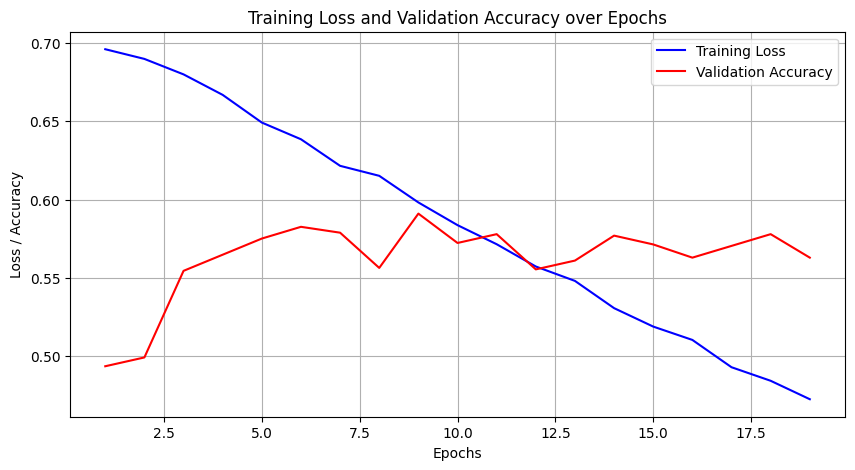

In [26]:
plot_loss_accuracy(losses, accuracies)

We run the validation check again to make sure we've loaded the right model

In [27]:
max_pool_val_accuracy = validate(model, val_dataloader)

Accuracy: 0.5910


Test the model on the test set to obtain the accuracy

In [28]:
max_pool_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.5741


## Results

In [29]:
print(f"RNN Validation Accuracy:        {rnn_val_accuracy:.4f}")
print(f"RNN Test Accuracy:              {rnn_tst_accuracy:.4f}")
print(f"Last State Validation Accuracy: {last_state_val_accuracy:.4f}")
print(f"Last State Test Accuracy:       {last_state_tst_accuracy:.4f}")
print(f"Mean Pool Validation Accuracy:  {mean_pool_val_accuracy:.4f}")
print(f"Mean Pool Test Accuracy:        {mean_pool_tst_accuracy:.4f}")
print(f"Max Pool Validation Accuracy:   {max_pool_val_accuracy:.4f}")
print(f"Max Pool Test Accuracy:         {max_pool_tst_accuracy:.4f}")

RNN Validation Accuracy:        0.5985
RNN Test Accuracy:              0.5985
Last State Validation Accuracy: 0.5966
Last State Test Accuracy:       0.5994
Mean Pool Validation Accuracy:  0.5891
Mean Pool Test Accuracy:        0.5591
Max Pool Validation Accuracy:   0.5910
Max Pool Test Accuracy:         0.5741


Based on the 4 visualisations and accuracy values, we can see that the best performing model is the one that uses Last State.